In [55]:
alpha = 255.0/(255+196)
beta = 1.0 - alpha
print(alpha)
print(beta)

#CNN
cnn1 = 0.9427
cnn2 = 0.8146
print(alpha * cnn1 + beta * cnn2)
dsv_cnn1 = 0.0082
dsv_cnn2 = 0.0217
print(alpha * dsv_cnn1 + beta * dsv_cnn2)


#RF
rf1 = 0.9261
rf2 = 0.8366
print(alpha * rf1 + beta * rf2)
dsv_rf1 = 0.0152
dsv_rf2 = 0.0096
print(alpha * dsv_rf1 + beta * dsv_rf2)

0.565410199556541
0.43458980044345896
0.8870290465631929
0.014066962305986697
0.8872042128603104
0.01276629711751663


In [1]:
import sys
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras import regularizers
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline

print(keras.__version__)

Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.
2.0.8


# 'known' train, 'unknown' test - Best CNN

In [6]:
train_tactile_images = np.load('images-known-t7-cero2mean-stdnorm-3d.npy')
train_labels = np.load('labels-known-t7-cero2mean-stdnorm-3d.npy')

test_tactile_images = np.load('images-unknown-t7-cero2mean-stdnorm-3d.npy')
test_labels = np.load('labels-unknown-t7-cero2mean-stdnorm-3d.npy')

FINGERS = 3
TACTILE_IMAGE_ROWS = 12
TACTILE_IMAGE_COLS = 11

train_labels_cat = np_utils.to_categorical(train_labels, num_classes=2)
test_labels_cat = np_utils.to_categorical(test_labels, num_classes=2)

print(train_tactile_images.shape)
print(test_tactile_images.shape)

(10320, 3, 12, 11)
(485, 3, 12, 11)


In [8]:
# ON THE PLAIN DATASET

folds = 10
cv_accuracies = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(train_tactile_images, train_labels_cat)
    shuffle(test_tactile_images, test_labels_cat) 
    
    # build model
    epochs = 300
    batch = 32
    
    learning_rate = 0.0001
    epsilon = 1e-08
    decay_rate = 0.005
    
    l2_reg = 0.01
    drop_prob = 0.0
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(FINGERS, TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS), 
                     data_format='channels_first',
                     use_bias=False, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Dropout(drop_prob))
    
    model.add(Dense(2, activation='softmax'))
    
    # compile and train
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate, epsilon=epsilon, decay=decay_rate), 
                  metrics=['accuracy'])
    model.fit(train_tactile_images, train_labels_cat, epochs=epochs, batch_size=batch, verbose=1)
    
    # evaluate
    print("# # # Evaluating cv-fold...")
    scores = model.evaluate(test_tactile_images, test_labels_cat, verbose=1)
    cv_accuracies.append(scores[1] * 100)
    
    predictions = model.predict(test_tactile_images)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(np.argmax(test_labels_cat, axis=1), 
                                                                          np.argmax(predictions, axis=1), 
                                                                          average='binary', pos_label=1)
    
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    
    print("\naccuracy:", scores[1] * 100)
    print("precision:", precision * 100)
    print("recall:", recall * 100)
    print("f1_score:", f1_score * 100)
    
print("\nFinal cross-validation score:")
print(np.mean(cv_accuracies), "+/-", np.std(cv_accuracies))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

# IROS
#86.0355987113 +/- 0.383259524026
#86.47674489 +/- 0.501892412426
#83.8644067797 +/- 0.775967670662
#85.1477152443 +/- 0.441251814143

Training fold 1/10
Epoch 1/300
2064/2064 [==============================] - 1s - loss: 14.0601 - acc: 0.8542     
Epoch 2/300
2064/2064 [==============================] - 0s - loss: 11.5612 - acc: 0.9036     
Epoch 3/300
2064/2064 [==============================] - 0s - loss: 9.9372 - acc: 0.9172     
Epoch 4/300
2064/2064 [==============================] - 0s - loss: 8.7771 - acc: 0.9273     
Epoch 5/300
2064/2064 [==============================] - 0s - loss: 7.9054 - acc: 0.9419     
Epoch 6/300
2064/2064 [==============================] - 0s - loss: 7.2133 - acc: 0.9530     
Epoch 7/300
2064/2064 [==============================] - 0s - loss: 6.6621 - acc: 0.9540     
Epoch 8/300
2064/2064 [==============================] - 0s - loss: 6.2209 - acc: 0.9491     
Epoch 9/300
2064/2064 [==============================] - 0s - loss: 5.8375 - acc: 0.9603     
Epoch 10/300
2064/2064 [==============================] - 0s - loss: 5.5166 - acc: 0.9608     
Epoch 11/300
2064/2064 [==============

2064/2064 [==============================] - 0s - loss: 1.8185 - acc: 0.9942     
Epoch 88/300
2064/2064 [==============================] - 0s - loss: 1.8090 - acc: 0.9952     
Epoch 89/300
2064/2064 [==============================] - 0s - loss: 1.7993 - acc: 0.9947     
Epoch 90/300
2064/2064 [==============================] - 0s - loss: 1.7926 - acc: 0.9942     
Epoch 91/300
2064/2064 [==============================] - 0s - loss: 1.7816 - acc: 0.9961     
Epoch 92/300
2064/2064 [==============================] - 0s - loss: 1.7692 - acc: 0.9952     
Epoch 93/300
2064/2064 [==============================] - 0s - loss: 1.7630 - acc: 0.9956     
Epoch 94/300
2064/2064 [==============================] - 0s - loss: 1.7573 - acc: 0.9932     
Epoch 95/300
2064/2064 [==============================] - 0s - loss: 1.7462 - acc: 0.9952     
Epoch 96/300
2064/2064 [==============================] - 0s - loss: 1.7391 - acc: 0.9927     
Epoch 97/300
2064/2064 [==============================] - 0s - 

2064/2064 [==============================] - 0s - loss: 1.1173 - acc: 0.9981     
Epoch 258/300
2064/2064 [==============================] - 0s - loss: 1.1158 - acc: 0.9976     
Epoch 259/300
2064/2064 [==============================] - 0s - loss: 1.1154 - acc: 0.9981     
Epoch 260/300
2064/2064 [==============================] - 0s - loss: 1.1140 - acc: 0.9981     
Epoch 261/300
2064/2064 [==============================] - 0s - loss: 1.1126 - acc: 0.9971     
Epoch 262/300
2064/2064 [==============================] - 0s - loss: 1.1086 - acc: 0.9990     
Epoch 263/300
2064/2064 [==============================] - 0s - loss: 1.1064 - acc: 0.9985     
Epoch 264/300
2064/2064 [==============================] - 0s - loss: 1.1073 - acc: 0.9971     
Epoch 265/300
2064/2064 [==============================] - 0s - loss: 1.1016 - acc: 0.9995     
Epoch 266/300
2064/2064 [==============================] - 0s - loss: 1.0984 - acc: 0.9985     
Epoch 267/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 1.4354 - acc: 0.9971     
Epoch 126/300
2064/2064 [==============================] - 0s - loss: 1.4287 - acc: 0.9981     
Epoch 127/300
2064/2064 [==============================] - 0s - loss: 1.4205 - acc: 0.9971     
Epoch 128/300
2064/2064 [==============================] - 0s - loss: 1.4180 - acc: 0.9952     
Epoch 129/300
2064/2064 [==============================] - 0s - loss: 1.4140 - acc: 0.9961     
Epoch 130/300
2064/2064 [==============================] - 0s - loss: 1.4108 - acc: 0.9956     
Epoch 131/300
2064/2064 [==============================] - 0s - loss: 1.4071 - acc: 0.9956     
Epoch 132/300
2064/2064 [==============================] - 0s - loss: 1.3983 - acc: 0.9966     
Epoch 133/300
2064/2064 [==============================] - 0s - loss: 1.3903 - acc: 0.9981     
Epoch 134/300
2064/2064 [==============================] - 0s - loss: 1.3899 - acc: 0.9956     
Epoch 135/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 0.9682 - acc: 0.9990     
Epoch 296/300
2064/2064 [==============================] - 0s - loss: 0.9694 - acc: 0.9990     
Epoch 297/300
2064/2064 [==============================] - 0s - loss: 0.9663 - acc: 0.9985     
Epoch 298/300
2064/2064 [==============================] - 0s - loss: 0.9666 - acc: 0.9981     
Epoch 299/300
2064/2064 [==============================] - 0s - loss: 0.9637 - acc: 0.9985     
Epoch 300/300
2064/2064 [==============================] - 0s - loss: 0.9652 - acc: 0.9981     
# # # Evaluating cv-fold...
 32/485 [>.............................] - ETA: 3s
accuracy: 87.83505155868137
precision: 89.47368421052632
recall: 85.35564853556485
f1_score: 87.36616702355462
Training fold 3/10
Epoch 1/300
2064/2064 [==============================] - 1s - loss: 14.0985 - acc: 0.8498     
Epoch 2/300
2064/2064 [==============================] - 0s - loss: 11.5922 - acc: 0.9031     
Epoch 3/300
2064/2064 [================

2064/2064 [==============================] - 0s - loss: 1.3647 - acc: 0.9981     
Epoch 165/300
2064/2064 [==============================] - 0s - loss: 1.3635 - acc: 0.9976     
Epoch 166/300
2064/2064 [==============================] - 0s - loss: 1.3581 - acc: 0.9985     
Epoch 167/300
2064/2064 [==============================] - 0s - loss: 1.3516 - acc: 0.9981     
Epoch 168/300
2064/2064 [==============================] - 0s - loss: 1.3521 - acc: 0.9981     
Epoch 169/300
2064/2064 [==============================] - 0s - loss: 1.3472 - acc: 0.9966     
Epoch 170/300
2064/2064 [==============================] - 0s - loss: 1.3429 - acc: 0.9976     
Epoch 171/300
2064/2064 [==============================] - 0s - loss: 1.3390 - acc: 0.9981     
Epoch 172/300
2064/2064 [==============================] - 0s - loss: 1.3359 - acc: 0.9976     
Epoch 173/300
2064/2064 [==============================] - 0s - loss: 1.3336 - acc: 0.9976     
Epoch 174/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 2.9537 - acc: 0.9840     
Epoch 33/300
2064/2064 [==============================] - 0s - loss: 2.9084 - acc: 0.9874     
Epoch 34/300
2064/2064 [==============================] - 0s - loss: 2.8613 - acc: 0.9855     
Epoch 35/300
2064/2064 [==============================] - 0s - loss: 2.8196 - acc: 0.9855     
Epoch 36/300
2064/2064 [==============================] - 0s - loss: 2.7835 - acc: 0.9845     
Epoch 37/300
2064/2064 [==============================] - 0s - loss: 2.7420 - acc: 0.9889     
Epoch 38/300
2064/2064 [==============================] - 0s - loss: 2.7043 - acc: 0.9869     
Epoch 39/300
2064/2064 [==============================] - 0s - loss: 2.6743 - acc: 0.9884     
Epoch 40/300
2064/2064 [==============================] - 0s - loss: 2.6336 - acc: 0.9893     
Epoch 41/300
2064/2064 [==============================] - 0s - loss: 2.6008 - acc: 0.9893     
Epoch 42/300
2064/2064 [==============================] - 0s - 

2064/2064 [==============================] - 0s - loss: 1.1984 - acc: 0.9985     
Epoch 203/300
2064/2064 [==============================] - 0s - loss: 1.1967 - acc: 0.9985     
Epoch 204/300
2064/2064 [==============================] - 0s - loss: 1.1953 - acc: 0.9971     
Epoch 205/300
2064/2064 [==============================] - 0s - loss: 1.1937 - acc: 0.9976     
Epoch 206/300
2064/2064 [==============================] - 0s - loss: 1.1871 - acc: 0.9990     
Epoch 207/300
2064/2064 [==============================] - 0s - loss: 1.1870 - acc: 0.9981     
Epoch 208/300
2064/2064 [==============================] - 0s - loss: 1.1823 - acc: 0.9985     
Epoch 209/300
2064/2064 [==============================] - 0s - loss: 1.1806 - acc: 0.9985     
Epoch 210/300
2064/2064 [==============================] - 0s - loss: 1.1784 - acc: 0.9981     
Epoch 211/300
2064/2064 [==============================] - 0s - loss: 1.1750 - acc: 0.9985     
Epoch 212/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 1.9196 - acc: 0.9864     
Epoch 72/300
2064/2064 [==============================] - 0s - loss: 1.8953 - acc: 0.9942     
Epoch 73/300
2064/2064 [==============================] - 0s - loss: 1.8838 - acc: 0.9952     
Epoch 74/300
2064/2064 [==============================] - 0s - loss: 1.8688 - acc: 0.9937     
Epoch 75/300
2064/2064 [==============================] - 0s - loss: 1.8578 - acc: 0.9952     
Epoch 76/300
2064/2064 [==============================] - 0s - loss: 1.8452 - acc: 0.9947     
Epoch 77/300
2064/2064 [==============================] - 0s - loss: 1.8401 - acc: 0.9918     
Epoch 78/300
2064/2064 [==============================] - 0s - loss: 1.8234 - acc: 0.9937     
Epoch 79/300
2064/2064 [==============================] - 0s - loss: 1.8170 - acc: 0.9942     
Epoch 80/300
2064/2064 [==============================] - 0s - loss: 1.8012 - acc: 0.9947     
Epoch 81/300
2064/2064 [==============================] - 0s - 

2064/2064 [==============================] - 0s - loss: 1.0787 - acc: 0.9981     
Epoch 242/300
2064/2064 [==============================] - 0s - loss: 1.0756 - acc: 0.9985     
Epoch 243/300
2064/2064 [==============================] - 0s - loss: 1.0739 - acc: 0.9985     
Epoch 244/300
2064/2064 [==============================] - 0s - loss: 1.0719 - acc: 0.9981     
Epoch 245/300
2064/2064 [==============================] - 0s - loss: 1.0735 - acc: 0.9981     
Epoch 246/300
2064/2064 [==============================] - 0s - loss: 1.0686 - acc: 0.9990     
Epoch 247/300
2064/2064 [==============================] - 0s - loss: 1.0657 - acc: 0.9985     
Epoch 248/300
2064/2064 [==============================] - 0s - loss: 1.0638 - acc: 0.9985     
Epoch 249/300
2064/2064 [==============================] - 0s - loss: 1.0639 - acc: 0.9985     
Epoch 250/300
2064/2064 [==============================] - 0s - loss: 1.0612 - acc: 0.9985     
Epoch 251/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 1.5788 - acc: 0.9976     
Epoch 110/300
2064/2064 [==============================] - 0s - loss: 1.5769 - acc: 0.9937     
Epoch 111/300
2064/2064 [==============================] - 0s - loss: 1.5671 - acc: 0.9956     
Epoch 112/300
2064/2064 [==============================] - 0s - loss: 1.5600 - acc: 0.9976     
Epoch 113/300
2064/2064 [==============================] - 0s - loss: 1.5520 - acc: 0.9990     
Epoch 114/300
2064/2064 [==============================] - 0s - loss: 1.5520 - acc: 0.9956     
Epoch 115/300
2064/2064 [==============================] - 0s - loss: 1.5406 - acc: 0.9981     
Epoch 116/300
2064/2064 [==============================] - 0s - loss: 1.5376 - acc: 0.9952     
Epoch 117/300
2064/2064 [==============================] - 0s - loss: 1.5269 - acc: 0.9966     
Epoch 118/300
2064/2064 [==============================] - 0s - loss: 1.5235 - acc: 0.9952     
Epoch 119/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 1.0005 - acc: 0.9985     
Epoch 280/300
2064/2064 [==============================] - 0s - loss: 1.0018 - acc: 0.9985     
Epoch 281/300
2064/2064 [==============================] - 0s - loss: 0.9978 - acc: 0.9985     
Epoch 282/300
2064/2064 [==============================] - 0s - loss: 0.9979 - acc: 0.9985     
Epoch 283/300
2064/2064 [==============================] - 0s - loss: 0.9945 - acc: 0.9990     
Epoch 284/300
2064/2064 [==============================] - 0s - loss: 0.9909 - acc: 0.9995     
Epoch 285/300
2064/2064 [==============================] - 0s - loss: 0.9898 - acc: 0.9990     
Epoch 286/300
2064/2064 [==============================] - 0s - loss: 0.9902 - acc: 0.9985     
Epoch 287/300
2064/2064 [==============================] - 0s - loss: 0.9874 - acc: 0.9990     
Epoch 288/300
2064/2064 [==============================] - 0s - loss: 0.9873 - acc: 0.9985     
Epoch 289/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 1.4061 - acc: 0.9985     
Epoch 148/300
2064/2064 [==============================] - 0s - loss: 1.4030 - acc: 0.9971     
Epoch 149/300
2064/2064 [==============================] - 0s - loss: 1.3987 - acc: 0.9981     
Epoch 150/300
2064/2064 [==============================] - 0s - loss: 1.3926 - acc: 0.9971     
Epoch 151/300
2064/2064 [==============================] - 0s - loss: 1.3887 - acc: 0.9976     
Epoch 152/300
2064/2064 [==============================] - 0s - loss: 1.3841 - acc: 0.9966     - ETA: 0s - loss: 1.3822 - 
Epoch 153/300
2064/2064 [==============================] - 0s - loss: 1.3799 - acc: 0.9981     
Epoch 154/300
2064/2064 [==============================] - 0s - loss: 1.3771 - acc: 0.9971     
Epoch 155/300
2064/2064 [==============================] - 0s - loss: 1.3702 - acc: 0.9990     
Epoch 156/300
2064/2064 [==============================] - 0s - loss: 1.3637 - acc: 0.9981     
Epoch 157/300
2064/2064 [==

2064/2064 [==============================] - 0s - loss: 4.5712 - acc: 0.9738     
Epoch 15/300
2064/2064 [==============================] - 0s - loss: 4.4109 - acc: 0.9690     
Epoch 16/300
2064/2064 [==============================] - 0s - loss: 4.2462 - acc: 0.9729     
Epoch 17/300
2064/2064 [==============================] - 0s - loss: 4.1148 - acc: 0.9729     
Epoch 18/300
2064/2064 [==============================] - 0s - loss: 3.9892 - acc: 0.9738     
Epoch 19/300
2064/2064 [==============================] - 0s - loss: 3.8735 - acc: 0.9714     
Epoch 20/300
2064/2064 [==============================] - 0s - loss: 3.7674 - acc: 0.9758     
Epoch 21/300
2064/2064 [==============================] - 0s - loss: 3.6740 - acc: 0.9734     
Epoch 22/300
2064/2064 [==============================] - 0s - loss: 3.5806 - acc: 0.9797     
Epoch 23/300
2064/2064 [==============================] - 0s - loss: 3.4942 - acc: 0.9806     
Epoch 24/300
2064/2064 [==============================] - 0s - 

2064/2064 [==============================] - 0s - loss: 1.2632 - acc: 0.9976     
Epoch 186/300
2064/2064 [==============================] - 0s - loss: 1.2606 - acc: 0.9976     
Epoch 187/300
2064/2064 [==============================] - 0s - loss: 1.2566 - acc: 0.9976     
Epoch 188/300
2064/2064 [==============================] - 0s - loss: 1.2549 - acc: 0.9976     
Epoch 189/300
2064/2064 [==============================] - 0s - loss: 1.2503 - acc: 0.9981     
Epoch 190/300
2064/2064 [==============================] - 0s - loss: 1.2466 - acc: 0.9985     
Epoch 191/300
2064/2064 [==============================] - 0s - loss: 1.2464 - acc: 0.9985     
Epoch 192/300
2064/2064 [==============================] - 0s - loss: 1.2420 - acc: 0.9981     
Epoch 193/300
2064/2064 [==============================] - 0s - loss: 1.2392 - acc: 0.9976     
Epoch 194/300
2064/2064 [==============================] - 0s - loss: 1.2361 - acc: 0.9971     
Epoch 195/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 2.2867 - acc: 0.9908     
Epoch 53/300
2064/2064 [==============================] - 0s - loss: 2.2642 - acc: 0.9947     
Epoch 54/300
2064/2064 [==============================] - 0s - loss: 2.2500 - acc: 0.9893     
Epoch 55/300
2064/2064 [==============================] - 0s - loss: 2.2285 - acc: 0.9927     
Epoch 56/300
2064/2064 [==============================] - 0s - loss: 2.2047 - acc: 0.9913     
Epoch 57/300
2064/2064 [==============================] - 0s - loss: 2.1864 - acc: 0.9932     
Epoch 58/300
2064/2064 [==============================] - 0s - loss: 2.1681 - acc: 0.9922     
Epoch 59/300
2064/2064 [==============================] - 0s - loss: 2.1532 - acc: 0.9908     
Epoch 60/300
2064/2064 [==============================] - 0s - loss: 2.1373 - acc: 0.9908     
Epoch 61/300
2064/2064 [==============================] - 0s - loss: 2.1145 - acc: 0.9937     
Epoch 62/300
2064/2064 [==============================] - 0s - 

2064/2064 [==============================] - 0s - loss: 1.1382 - acc: 0.9990     
Epoch 223/300
2064/2064 [==============================] - 0s - loss: 1.1376 - acc: 0.9985     
Epoch 224/300
2064/2064 [==============================] - 0s - loss: 1.1346 - acc: 0.9985     
Epoch 225/300
2064/2064 [==============================] - 0s - loss: 1.1335 - acc: 0.9981     
Epoch 226/300
2064/2064 [==============================] - 0s - loss: 1.1274 - acc: 0.9985     
Epoch 227/300
2064/2064 [==============================] - 0s - loss: 1.1264 - acc: 0.9990     
Epoch 228/300
2064/2064 [==============================] - 0s - loss: 1.1246 - acc: 0.9985     
Epoch 229/300
2064/2064 [==============================] - 0s - loss: 1.1229 - acc: 0.9990     
Epoch 230/300
2064/2064 [==============================] - 0s - loss: 1.1200 - acc: 0.9985     
Epoch 231/300
2064/2064 [==============================] - 0s - loss: 1.1213 - acc: 0.9985     
Epoch 232/300
2064/2064 [=============================

2064/2064 [==============================] - 0s - loss: 1.7231 - acc: 0.9971     
Epoch 92/300
2064/2064 [==============================] - 0s - loss: 1.7150 - acc: 0.9942     
Epoch 93/300
2064/2064 [==============================] - 0s - loss: 1.7069 - acc: 0.9942     
Epoch 94/300
2064/2064 [==============================] - 0s - loss: 1.6950 - acc: 0.9976     
Epoch 95/300
2064/2064 [==============================] - 0s - loss: 1.6862 - acc: 0.9966     
Epoch 96/300
2064/2064 [==============================] - 0s - loss: 1.6801 - acc: 0.9937     
Epoch 97/300
2064/2064 [==============================] - 0s - loss: 1.6686 - acc: 0.9971     
Epoch 98/300
2064/2064 [==============================] - 0s - loss: 1.6615 - acc: 0.9952     
Epoch 99/300
2064/2064 [==============================] - 0s - loss: 1.6519 - acc: 0.9956     
Epoch 100/300
2064/2064 [==============================] - 0s - loss: 1.6428 - acc: 0.9971     
Epoch 101/300
2064/2064 [==============================] - 0s 

2064/2064 [==============================] - 0s - loss: 0.9958 - acc: 0.9990     
Epoch 262/300
2064/2064 [==============================] - 0s - loss: 0.9934 - acc: 0.9985     
Epoch 263/300
2064/2064 [==============================] - 0s - loss: 0.9909 - acc: 0.9990     
Epoch 264/300
2064/2064 [==============================] - 0s - loss: 0.9911 - acc: 0.9995     
Epoch 265/300
2064/2064 [==============================] - 0s - loss: 0.9883 - acc: 0.9995     
Epoch 266/300
2064/2064 [==============================] - 0s - loss: 0.9852 - acc: 0.9990     
Epoch 267/300
2064/2064 [==============================] - 0s - loss: 0.9848 - acc: 0.9990     
Epoch 268/300
2064/2064 [==============================] - 0s - loss: 0.9820 - acc: 0.9995     
Epoch 269/300
2064/2064 [==============================] - 0s - loss: 0.9802 - acc: 0.9981     
Epoch 270/300
2064/2064 [==============================] - 0s - loss: 0.9771 - acc: 0.9990     
Epoch 271/300
2064/2064 [=============================

In [21]:
# ON THE AUGMENTED DATASET WITH FLIPLR

folds = 10
cv_accuracies = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(train_tactile_images, train_labels_cat)
    shuffle(test_tactile_images, test_labels_cat) 
    
    # build model
    epochs = 30
    batch = 32
    
    learning_rate = 0.0001
    epsilon = 1e-08
    decay_rate = 0.005
    
    l2_reg = 0.015
    drop_prob = 0.25
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(FINGERS, TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS), 
                     data_format='channels_first',
                     use_bias=False, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Dropout(drop_prob))
    
    model.add(Dense(2, activation='softmax'))

    # compile and train
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate, epsilon=epsilon, decay=decay_rate), 
                  metrics=['accuracy'])
    model.fit(train_tactile_images, train_labels_cat, epochs=epochs, batch_size=batch, verbose=1)
    
    # evaluate
    print("# # # Evaluating cv-fold...")
    scores = model.evaluate(test_tactile_images, test_labels_cat, verbose=1)
    cv_accuracies.append(scores[1] * 100)
    
    predictions = model.predict(test_tactile_images)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(np.argmax(test_labels_cat, axis=1), 
                                                                          np.argmax(predictions, axis=1), 
                                                                          average='binary', pos_label=1)
    
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    
    print("\naccuracy:", scores[1] * 100)
    print("precision:", precision * 100)
    print("recall:", recall * 100)
    print("f1_score:", f1_score * 100)
    
print("\nFinal cross-validation score:")
print(np.mean(cv_accuracies), "+/-", np.std(cv_accuracies))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

# IROS
#86.0355987113 +/- 0.383259524026
#86.47674489 +/- 0.501892412426
#83.8644067797 +/- 0.775967670662
#85.1477152443 +/- 0.441251814143

Training fold 1/10
Epoch 1/30
4128/4128 [==============================] - 3s - loss: 19.2793 - acc: 0.8266     
Epoch 2/30
4128/4128 [==============================] - 1s - loss: 14.1680 - acc: 0.8861     
Epoch 3/30
4128/4128 [==============================] - 1s - loss: 11.5231 - acc: 0.8878     
Epoch 4/30
4128/4128 [==============================] - 1s - loss: 9.8751 - acc: 0.8937     
Epoch 5/30
4128/4128 [==============================] - 1s - loss: 8.7448 - acc: 0.9050     
Epoch 6/30
4128/4128 [==============================] - 1s - loss: 7.9292 - acc: 0.9109     
Epoch 7/30
4128/4128 [==============================] - 1s - loss: 7.2951 - acc: 0.9155     
Epoch 8/30
4128/4128 [==============================] - 1s - loss: 6.8030 - acc: 0.9184     
Epoch 9/30
4128/4128 [==============================] - 1s - loss: 6.3947 - acc: 0.9271     
Epoch 10/30
4128/4128 [==============================] - 1s - loss: 6.0653 - acc: 0.9259     
Epoch 11/30
4128/4128 [========================

4128/4128 [==============================] - 1s - loss: 5.3290 - acc: 0.9351     
Epoch 14/30
4128/4128 [==============================] - 1s - loss: 5.1492 - acc: 0.9356     
Epoch 15/30
4128/4128 [==============================] - 1s - loss: 4.9870 - acc: 0.9387     
Epoch 16/30
4128/4128 [==============================] - 1s - loss: 4.8378 - acc: 0.9450     
Epoch 17/30
4128/4128 [==============================] - 1s - loss: 4.7207 - acc: 0.9419     
Epoch 18/30
4128/4128 [==============================] - 1s - loss: 4.6019 - acc: 0.9392     
Epoch 19/30
4128/4128 [==============================] - 1s - loss: 4.4895 - acc: 0.9479     
Epoch 20/30
4128/4128 [==============================] - 1s - loss: 4.3881 - acc: 0.9462     
Epoch 21/30
4128/4128 [==============================] - 1s - loss: 4.2965 - acc: 0.9491     
Epoch 22/30
4128/4128 [==============================] - 1s - loss: 4.2181 - acc: 0.9489     
Epoch 23/30
4128/4128 [==============================] - 1s - loss: 4.13

In [24]:
# ON THE AUGMENTED DATASET WITH FLIPLR AND FLIPUD

folds = 10
cv_accuracies = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(train_tactile_images, train_labels_cat)
    shuffle(test_tactile_images, test_labels_cat) 
    
    # build model
    epochs = 30
    batch = 32
    
    learning_rate = 0.0001
    epsilon = 1e-08
    decay_rate = 0.005
    
    l2_reg = 0.015
    drop_prob = 0.25
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(FINGERS, TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS), 
                     data_format='channels_first',
                     use_bias=False, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Dropout(drop_prob))
    
    model.add(Dense(2, activation='softmax'))

    # compile and train
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate, epsilon=epsilon, decay=decay_rate), 
                  metrics=['accuracy'])
    model.fit(train_tactile_images, train_labels_cat, epochs=epochs, batch_size=batch, verbose=1)
    
    # evaluate
    print("# # # Evaluating cv-fold...")
    scores = model.evaluate(test_tactile_images, test_labels_cat, verbose=1)
    cv_accuracies.append(scores[1] * 100)
    
    predictions = model.predict(test_tactile_images)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(np.argmax(test_labels_cat, axis=1), 
                                                                          np.argmax(predictions, axis=1), 
                                                                          average='binary', pos_label=1)
    
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    
    print("\naccuracy:", scores[1] * 100)
    print("precision:", precision * 100)
    print("recall:", recall * 100)
    print("f1_score:", f1_score * 100)
    
print("\nFinal cross-validation score:")
print(np.mean(cv_accuracies), "+/-", np.std(cv_accuracies))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

# IROS
#86.0355987113 +/- 0.383259524026
#86.47674489 +/- 0.501892412426
#83.8644067797 +/- 0.775967670662
#85.1477152443 +/- 0.441251814143

Training fold 1/10
Epoch 1/30
6192/6192 [==============================] - 4s - loss: 18.0447 - acc: 0.8280     
Epoch 2/30
6192/6192 [==============================] - 2s - loss: 12.4967 - acc: 0.8742     
Epoch 3/30
6192/6192 [==============================] - 2s - loss: 10.0204 - acc: 0.8849     
Epoch 4/30
6192/6192 [==============================] - 2s - loss: 8.5823 - acc: 0.8947     
Epoch 5/30
6192/6192 [==============================] - 2s - loss: 7.6355 - acc: 0.9026     
Epoch 6/30
6192/6192 [==============================] - 2s - loss: 6.9625 - acc: 0.9042     
Epoch 7/30
6192/6192 [==============================] - 2s - loss: 6.4504 - acc: 0.9133     
Epoch 8/30
6192/6192 [==============================] - 2s - loss: 6.0520 - acc: 0.9155     
Epoch 9/30
6192/6192 [==============================] - 2s - loss: 5.7305 - acc: 0.9172     
Epoch 10/30
6192/6192 [==============================] - 2s - loss: 5.4671 - acc: 0.9173     
Epoch 11/30
6192/6192 [========================

6192/6192 [==============================] - 2s - loss: 4.9001 - acc: 0.9233     
Epoch 14/30
6192/6192 [==============================] - 2s - loss: 4.7566 - acc: 0.9267     - ETA: 1s - loss:
Epoch 15/30
6192/6192 [==============================] - 2s - loss: 4.6337 - acc: 0.9236     
Epoch 16/30
6192/6192 [==============================] - 2s - loss: 4.5137 - acc: 0.9294     
Epoch 17/30
6192/6192 [==============================] - 2s - loss: 4.4127 - acc: 0.9309     
Epoch 18/30
6192/6192 [==============================] - 2s - loss: 4.3210 - acc: 0.9323     
Epoch 19/30
6192/6192 [==============================] - 2s - loss: 4.2387 - acc: 0.9315     
Epoch 20/30
6192/6192 [==============================] - 2s - loss: 4.1594 - acc: 0.9317     
Epoch 21/30
6192/6192 [==============================] - 2s - loss: 4.0899 - acc: 0.9315     
Epoch 22/30
6192/6192 [==============================] - 2s - loss: 4.0239 - acc: 0.9328     
Epoch 23/30
6192/6192 [==============================] 

In [4]:
# ON THE AUGMENTED DATASET WITH FLIPLR, FLIPUD AND ROTATE10

folds = 10
cv_accuracies = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(train_tactile_images, train_labels_cat)
    shuffle(test_tactile_images, test_labels_cat) 
    
    # build model
    epochs = 30
    batch = 32
    
    learning_rate = 0.0001
    epsilon = 1e-08
    decay_rate = 0.005
    
    l2_reg = 0.015
    drop_prob = 0.25
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(FINGERS, TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS), 
                     data_format='channels_first',
                     use_bias=False, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Dropout(drop_prob))
    
    model.add(Dense(2, activation='softmax'))

    # compile and train
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate, epsilon=epsilon, decay=decay_rate), 
                  metrics=['accuracy'])
    model.fit(train_tactile_images, train_labels_cat, epochs=epochs, batch_size=batch, verbose=1)
    
    # evaluate
    print("# # # Evaluating cv-fold...")
    scores = model.evaluate(test_tactile_images, test_labels_cat, verbose=1)
    cv_accuracies.append(scores[1] * 100)
    
    predictions = model.predict(test_tactile_images)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(np.argmax(test_labels_cat, axis=1), 
                                                                          np.argmax(predictions, axis=1), 
                                                                          average='binary', pos_label=1)
    
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    
    print("\naccuracy:", scores[1] * 100)
    print("precision:", precision * 100)
    print("recall:", recall * 100)
    print("f1_score:", f1_score * 100)
    
print("\nFinal cross-validation score:")
print(np.mean(cv_accuracies), "+/-", np.std(cv_accuracies))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

# IROS
#86.0355987113 +/- 0.383259524026
#86.47674489 +/- 0.501892412426
#83.8644067797 +/- 0.775967670662
#85.1477152443 +/- 0.441251814143

Training fold 1/10
Epoch 1/30
8256/8256 [==============================] - 3s - loss: 17.0007 - acc: 0.8361     
Epoch 2/30
8256/8256 [==============================] - 2s - loss: 11.2165 - acc: 0.8752     
Epoch 3/30
8256/8256 [==============================] - 2s - loss: 8.9157 - acc: 0.8801     
Epoch 4/30
8256/8256 [==============================] - 2s - loss: 7.6333 - acc: 0.8947     
Epoch 5/30
8256/8256 [==============================] - 2s - loss: 6.7989 - acc: 0.9046     
Epoch 6/30
8256/8256 [==============================] - 2s - loss: 6.2182 - acc: 0.9067     
Epoch 7/30
8256/8256 [==============================] - 2s - loss: 5.7823 - acc: 0.9124     
Epoch 8/30
8256/8256 [==============================] - 2s - loss: 5.4416 - acc: 0.9146     
Epoch 9/30
8256/8256 [==============================] - 2s - loss: 5.1664 - acc: 0.9169     
Epoch 10/30
8256/8256 [==============================] - 2s - loss: 4.9412 - acc: 0.9213     
Epoch 11/30
8256/8256 [=========================

8256/8256 [==============================] - 2s - loss: 3.5868 - acc: 0.9396     
Epoch 24/30
8256/8256 [==============================] - 2s - loss: 3.5394 - acc: 0.9399     
Epoch 25/30
8256/8256 [==============================] - 2s - loss: 3.4908 - acc: 0.9427     - ETA: 1s -
Epoch 26/30
8256/8256 [==============================] - 2s - loss: 3.4527 - acc: 0.9404     
Epoch 27/30
8256/8256 [==============================] - 2s - loss: 3.4086 - acc: 0.9425     
Epoch 28/30
8256/8256 [==============================] - 2s - loss: 3.3689 - acc: 0.9432     
Epoch 29/30
8256/8256 [==============================] - 2s - loss: 3.3324 - acc: 0.9436     
Epoch 30/30
8256/8256 [==============================] - 2s - loss: 3.3036 - acc: 0.9415     
# # # Evaluating cv-fold...
 32/485 [>.............................] - ETA: 4s
accuracy: 89.48453610705346
precision: 91.96428571428571
recall: 86.19246861924687
f1_score: 88.98488120950323
Training fold 4/10
Epoch 1/30
8256/8256 [==================

8256/8256 [==============================] - 2s - loss: 4.4808 - acc: 0.9300     
Epoch 14/30
8256/8256 [==============================] - 2s - loss: 4.3686 - acc: 0.9233     
Epoch 15/30
8256/8256 [==============================] - 2s - loss: 4.2584 - acc: 0.9268     
Epoch 16/30
8256/8256 [==============================] - 2s - loss: 4.1568 - acc: 0.9273     
Epoch 17/30
8256/8256 [==============================] - 2s - loss: 4.0664 - acc: 0.9333     
Epoch 18/30
8256/8256 [==============================] - 2s - loss: 3.9935 - acc: 0.9314     
Epoch 19/30
8256/8256 [==============================] - 2s - loss: 3.9154 - acc: 0.9330     
Epoch 20/30
8256/8256 [==============================] - 2s - loss: 3.8498 - acc: 0.9310     
Epoch 21/30
8256/8256 [==============================] - 2s - loss: 3.7893 - acc: 0.9346     
Epoch 22/30
8256/8256 [==============================] - 2s - loss: 3.7297 - acc: 0.9380     
Epoch 23/30
8256/8256 [==============================] - 2s - loss: 3.67

8256/8256 [==============================] - 2s - loss: 8.8477 - acc: 0.8909     
Epoch 4/30
8256/8256 [==============================] - 2s - loss: 7.5762 - acc: 0.8958     
Epoch 5/30
8256/8256 [==============================] - 2s - loss: 6.7530 - acc: 0.9052     
Epoch 6/30
8256/8256 [==============================] - 2s - loss: 6.1746 - acc: 0.9099     
Epoch 7/30
8256/8256 [==============================] - 2s - loss: 5.7364 - acc: 0.9159     
Epoch 8/30
8256/8256 [==============================] - 2s - loss: 5.4054 - acc: 0.9159     
Epoch 9/30
8256/8256 [==============================] - 2s - loss: 5.1292 - acc: 0.9207     
Epoch 10/30
8256/8256 [==============================] - 2s - loss: 4.9022 - acc: 0.9259     
Epoch 11/30
8256/8256 [==============================] - 2s - loss: 4.7168 - acc: 0.9234     
Epoch 12/30
8256/8256 [==============================] - 2s - loss: 4.5594 - acc: 0.9270     
Epoch 13/30
8256/8256 [==============================] - 2s - loss: 4.4167 - a

In [7]:
# ON THE AUGMENTED DATASET WITH FLIPLR, FLIPUD, ROTATE10 AND ROTATE 10 MIRROR

folds = 10
cv_accuracies = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(train_tactile_images, train_labels_cat)
    shuffle(test_tactile_images, test_labels_cat) 
    
    # build model
    epochs = 30
    batch = 32
    
    learning_rate = 0.0001
    epsilon = 1e-08
    decay_rate = 0.005
    
    l2_reg = 0.015
    drop_prob = 0.25
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(FINGERS, TACTILE_IMAGE_ROWS, TACTILE_IMAGE_COLS), 
                     data_format='channels_first',
                     use_bias=False, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Dropout(drop_prob))
    
    model.add(Dense(2, activation='softmax'))

    # compile and train
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate, epsilon=epsilon, decay=decay_rate), 
                  metrics=['accuracy'])
    model.fit(train_tactile_images, train_labels_cat, epochs=epochs, batch_size=batch, verbose=1)
    
    # evaluate
    print("# # # Evaluating cv-fold...")
    scores = model.evaluate(test_tactile_images, test_labels_cat, verbose=1)
    cv_accuracies.append(scores[1] * 100)
    
    predictions = model.predict(test_tactile_images)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(np.argmax(test_labels_cat, axis=1), 
                                                                          np.argmax(predictions, axis=1), 
                                                                          average='binary', pos_label=1)
    
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    
    print("\naccuracy:", scores[1] * 100)
    print("precision:", precision * 100)
    print("recall:", recall * 100)
    print("f1_score:", f1_score * 100)
    
print("\nFinal cross-validation score:")
print(np.mean(cv_accuracies), "+/-", np.std(cv_accuracies))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

# IROS
#86.0355987113 +/- 0.383259524026
#86.47674489 +/- 0.501892412426
#83.8644067797 +/- 0.775967670662
#85.1477152443 +/- 0.441251814143

Training fold 1/10
Epoch 1/30
10320/10320 [==============================] - 4s - loss: 16.1067 - acc: 0.8386     
Epoch 2/30
10320/10320 [==============================] - 3s - loss: 10.1600 - acc: 0.8805     
Epoch 3/30
10320/10320 [==============================] - 3s - loss: 8.0138 - acc: 0.8849     
Epoch 4/30
10320/10320 [==============================] - 3s - loss: 6.8633 - acc: 0.8969     
Epoch 5/30
10320/10320 [==============================] - 3s - loss: 6.1396 - acc: 0.9042     
Epoch 6/30
10320/10320 [==============================] - 3s - loss: 5.6323 - acc: 0.9063     
Epoch 7/30
10320/10320 [==============================] - 3s - loss: 5.2568 - acc: 0.9121     
Epoch 8/30
10320/10320 [==============================] - 3s - loss: 4.9643 - acc: 0.9178     
Epoch 9/30
10320/10320 [==============================] - 3s - loss: 4.7343 - acc: 0.9151     
Epoch 10/30
10320/10320 [==============================] - 3s - loss: 4.5369 - acc: 0.9170     
Epoch 11/30
10320/10320 [===

10320/10320 [==============================] - 3s - loss: 3.5822 - acc: 0.9350     
Epoch 23/30
10320/10320 [==============================] - 3s - loss: 3.5379 - acc: 0.9367     
Epoch 24/30
10320/10320 [==============================] - 3s - loss: 3.4909 - acc: 0.9369     
Epoch 25/30
10320/10320 [==============================] - 3s - loss: 3.4498 - acc: 0.9349     
Epoch 26/30
10320/10320 [==============================] - 3s - loss: 3.4114 - acc: 0.9349     
Epoch 27/30
10320/10320 [==============================] - 3s - loss: 3.3713 - acc: 0.9394     
Epoch 28/30
10320/10320 [==============================] - 3s - loss: 3.3381 - acc: 0.9377     
Epoch 29/30
10320/10320 [==============================] - 3s - loss: 3.3042 - acc: 0.9390     
Epoch 30/30
10320/10320 [==============================] - 3s - loss: 3.2756 - acc: 0.9364     
# # # Evaluating cv-fold...
 32/485 [>.............................] - ETA: 7s
accuracy: 90.72164949682569
precision: 91.8103448275862
recall: 89.12

10320/10320 [==============================] - 3s - loss: 4.4822 - acc: 0.9221     
Epoch 12/30
10320/10320 [==============================] - 3s - loss: 4.3434 - acc: 0.9249     
Epoch 13/30
10320/10320 [==============================] - 3s - loss: 4.2151 - acc: 0.9270     
Epoch 14/30
10320/10320 [==============================] - 3s - loss: 4.1083 - acc: 0.9280     
Epoch 15/30
10320/10320 [==============================] - 3s - loss: 4.0164 - acc: 0.9239     
Epoch 16/30
10320/10320 [==============================] - 3s - loss: 3.9275 - acc: 0.9274     
Epoch 17/30
10320/10320 [==============================] - 3s - loss: 3.8437 - acc: 0.9332     
Epoch 18/30
10320/10320 [==============================] - 3s - loss: 3.7707 - acc: 0.9329     
Epoch 19/30
10320/10320 [==============================] - 3s - loss: 3.7077 - acc: 0.9339     
Epoch 20/30
10320/10320 [==============================] - 3s - loss: 3.6459 - acc: 0.9337     
Epoch 21/30
10320/10320 [===========================

Epoch 1/30
10320/10320 [==============================] - 5s - loss: 15.9906 - acc: 0.8371     
Epoch 2/30
10320/10320 [==============================] - 3s - loss: 10.0379 - acc: 0.8785     
Epoch 3/30
10320/10320 [==============================] - 3s - loss: 7.9059 - acc: 0.8893     
Epoch 4/30
10320/10320 [==============================] - 3s - loss: 6.7823 - acc: 0.8937     
Epoch 5/30
10320/10320 [==============================] - 3s - loss: 6.0709 - acc: 0.9007     
Epoch 6/30
10320/10320 [==============================] - 3s - loss: 5.5684 - acc: 0.9077     
Epoch 7/30
10320/10320 [==============================] - 3s - loss: 5.1973 - acc: 0.9105     
Epoch 8/30
10320/10320 [==============================] - 3s - loss: 4.9158 - acc: 0.9140     
Epoch 9/30
10320/10320 [==============================] - 3s - loss: 4.6785 - acc: 0.9197     
Epoch 10/30
10320/10320 [==============================] - 3s - loss: 4.4976 - acc: 0.9187     
Epoch 11/30
10320/10320 [======================

# 'known' train, 'unknown' test - Classic ML Methods

(2064, 72)
(485, 72)


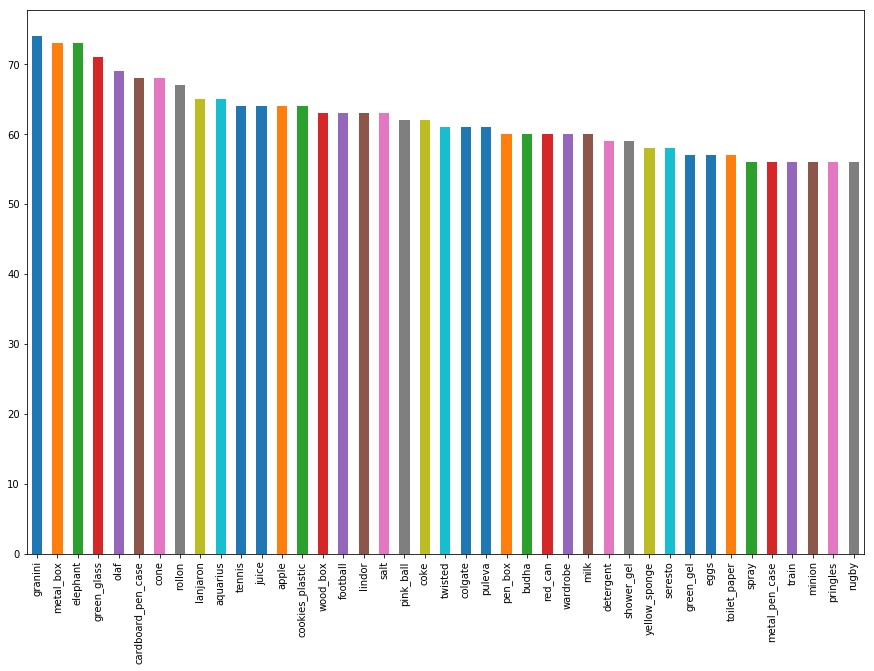

In [5]:
LAYING_RAW_DATA_FILE = 'laying_grasps.csv'
STANDING_RAW_DATA_FILE = 'standing_grasps.csv'

laying_raw_df = pd.read_csv(LAYING_RAW_DATA_FILE)
standing_raw_df = pd.read_csv(STANDING_RAW_DATA_FILE)
whole_raw_df = pd.concat([laying_raw_df, standing_raw_df])

whole_raw_df['object'].value_counts().plot(kind='bar', figsize=(15, 10))

#unknown_objects = ['metal_box', 'juice', 'aquarius', 'green_gel', 'tennis', 'football', 'milk', 'metal_pen_case', 'train', 'budha']
#unknown_objects = ['metal_box', 'football', 'budha']
unknown_objects = ['juice', 'aquarius', 'green_gel', 'tennis', 'football', 'milk', 'metal_pen_case', 'train']

unknown_raw_df = whole_raw_df.loc[whole_raw_df['object'].isin(unknown_objects)]
known_raw_df = whole_raw_df.loc[~whole_raw_df['object'].isin(unknown_objects)]

known_labels = known_raw_df['slipped'].values
known_tactiles = known_raw_df[['ff_biotac_1', 'ff_biotac_2', 'ff_biotac_3', 'ff_biotac_4', 'ff_biotac_5', 
                   'ff_biotac_6', 'ff_biotac_7', 'ff_biotac_8', 'ff_biotac_9', 'ff_biotac_10', 'ff_biotac_11', 
                   'ff_biotac_12', 'ff_biotac_13', 'ff_biotac_14', 'ff_biotac_15', 'ff_biotac_16', 'ff_biotac_17', 
                   'ff_biotac_18', 'ff_biotac_19', 'ff_biotac_20', 'ff_biotac_21', 'ff_biotac_22', 'ff_biotac_23', 
                   'ff_biotac_24', 'mf_biotac_1', 'mf_biotac_2', 'mf_biotac_3', 'mf_biotac_4', 'mf_biotac_5', 
                   'mf_biotac_6', 'mf_biotac_7', 'mf_biotac_8', 'mf_biotac_9', 'mf_biotac_10', 'mf_biotac_11', 
                   'mf_biotac_12', 'mf_biotac_13', 'mf_biotac_14', 'mf_biotac_15', 'mf_biotac_16', 'mf_biotac_17', 
                   'mf_biotac_18', 'mf_biotac_19', 'mf_biotac_20', 'mf_biotac_21', 'mf_biotac_22', 'mf_biotac_23', 
                   'mf_biotac_24', 'th_biotac_1', 'th_biotac_2', 'th_biotac_3', 'th_biotac_4', 'th_biotac_5', 
                   'th_biotac_6', 'th_biotac_7', 'th_biotac_8', 'th_biotac_9', 'th_biotac_10', 'th_biotac_11', 
                   'th_biotac_12', 'th_biotac_13', 'th_biotac_14', 'th_biotac_15', 'th_biotac_16', 'th_biotac_17', 
                   'th_biotac_18', 'th_biotac_19', 'th_biotac_20', 'th_biotac_21', 'th_biotac_22', 'th_biotac_23', 
                   'th_biotac_24']].values

unknown_labels = unknown_raw_df['slipped'].values
unknown_tactiles = unknown_raw_df[['ff_biotac_1', 'ff_biotac_2', 'ff_biotac_3', 'ff_biotac_4', 'ff_biotac_5', 
                   'ff_biotac_6', 'ff_biotac_7', 'ff_biotac_8', 'ff_biotac_9', 'ff_biotac_10', 'ff_biotac_11', 
                   'ff_biotac_12', 'ff_biotac_13', 'ff_biotac_14', 'ff_biotac_15', 'ff_biotac_16', 'ff_biotac_17', 
                   'ff_biotac_18', 'ff_biotac_19', 'ff_biotac_20', 'ff_biotac_21', 'ff_biotac_22', 'ff_biotac_23', 
                   'ff_biotac_24', 'mf_biotac_1', 'mf_biotac_2', 'mf_biotac_3', 'mf_biotac_4', 'mf_biotac_5', 
                   'mf_biotac_6', 'mf_biotac_7', 'mf_biotac_8', 'mf_biotac_9', 'mf_biotac_10', 'mf_biotac_11', 
                   'mf_biotac_12', 'mf_biotac_13', 'mf_biotac_14', 'mf_biotac_15', 'mf_biotac_16', 'mf_biotac_17', 
                   'mf_biotac_18', 'mf_biotac_19', 'mf_biotac_20', 'mf_biotac_21', 'mf_biotac_22', 'mf_biotac_23', 
                   'mf_biotac_24', 'th_biotac_1', 'th_biotac_2', 'th_biotac_3', 'th_biotac_4', 'th_biotac_5', 
                   'th_biotac_6', 'th_biotac_7', 'th_biotac_8', 'th_biotac_9', 'th_biotac_10', 'th_biotac_11', 
                   'th_biotac_12', 'th_biotac_13', 'th_biotac_14', 'th_biotac_15', 'th_biotac_16', 'th_biotac_17', 
                   'th_biotac_18', 'th_biotac_19', 'th_biotac_20', 'th_biotac_21', 'th_biotac_22', 'th_biotac_23', 
                   'th_biotac_24']].values

print(known_tactiles.shape)
print(unknown_tactiles.shape)

known_tactiles = (known_tactiles - np.mean(known_tactiles)) / (np.std(known_tactiles))
unknown_tactiles = (unknown_tactiles - np.mean(unknown_tactiles)) / (np.std(unknown_tactiles))

In [10]:
# TESTING SVM

folds = 10

cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(known_tactiles, known_labels)
    shuffle(unknown_tactiles, unknown_labels)

    # train
    param_grid = {'C': [0.01, 0.1, 1, 1e1, 1e2, 1e3, 5e3], 'gamma': ['auto', 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=12)
    
    print(svm)
    
    svm.fit(known_tactiles, known_labels)
    
    # evaluate
    print("+ Evaluating cv-fold...")
    
    predictions = svm.predict(unknown_tactiles)
    
    accuracy = accuracy_score(unknown_labels, predictions)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(unknown_labels, predictions, average='binary', 
                                                                       pos_label=1)
    cv_accuracy.append(accuracy * 100)
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)

    print(svm.best_params_)
    print("->accuracy:", accuracy * 100)
    print("->precision:", precision * 100)
    print("->recall:", recall * 100)
    print("->f1_score:", f1_score * 100)
    print("\n")

print("\n@ Final cross-validation score @")
print(np.mean(cv_accuracy), "+/-", np.std(cv_accuracy))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

Training fold 1/10
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'C': [0.01, 0.1, 1, 10.0, 100.0, 1000.0, 5000.0], 'gamma': ['auto', 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
+ Evaluating cv-fold...
{'C': 1, 'gamma': 'auto'}
->accuracy: 89.89690721649485
->precision: 88.30645161290323
->recall: 91.63179916317992
->f1_score: 89.93839835728953


Training fold 2/10
GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=

In [12]:
# TESTING RF

folds = 10

cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(known_tactiles, known_labels)
    shuffle(unknown_tactiles, unknown_labels) 

    # train
    param_grid = {'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [None, 5, 10, 15, 20, 25, 30]}
    rf = GridSearchCV(RandomForestClassifier(oob_score=False), param_grid, n_jobs=12)
    
    print(rf)
    
    rf.fit(known_tactiles, known_labels)
    
    # evaluate
    print("+ Evaluating cv-fold...")
    
    predictions = rf.predict(unknown_tactiles)
    
    accuracy = accuracy_score(unknown_labels, predictions)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(unknown_labels, predictions, average='binary', 
                                                                       pos_label=1)
    cv_accuracy.append(accuracy * 100)
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)

    print(rf.best_params_)
    print("->accuracy:", accuracy * 100)
    print("->precision:", precision * 100)
    print("->recall:", recall * 100)
    print("->f1_score:", f1_score * 100)
    print("\n")

print("\n@ Final cross-validation score @")
print(np.mean(cv_accuracy), "+/-", np.std(cv_accuracy))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

Training fold 1/10
GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [None, 5, 10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
+ Evaluating cv-fold...
{'max_depth': None, 'n_estimators': 150}
->accuracy: 90.9278350515464
->precision: 92.95154185022027
->recall: 88.28451882845188
->f1_score: 90.55793991416309


Training fold 2/10
GridSearchCV(cv=None, error_score='raise',

+ Evaluating cv-fold...
{'max_depth': None, 'n_estimators': 100}
->accuracy: 89.69072164948454
->precision: 93.15068493150685
->recall: 85.35564853556485
->f1_score: 89.08296943231441


Training fold 10/10
GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [None, 5, 10, 15, 20, 25, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
+ Evaluating cv-fold...
{'max_depth': 30, 'n_estimators': 1

In [13]:
# TESTING K-NN

folds = 10

cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(known_tactiles, known_labels)
    shuffle(unknown_tactiles, unknown_labels) 

    # train
    param_grid = {'n_neighbors' : [1, 3, 5, 7, 9, 11, 13], }
    neigh = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=12)
    
    print(neigh)
    
    neigh.fit(known_tactiles, known_labels)
    
    # evaluate
    print("+ Evaluating cv-fold...")
    
    predictions = neigh.predict(unknown_tactiles)
    
    accuracy = accuracy_score(unknown_labels, predictions)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(unknown_labels, predictions, average='binary', 
                                                                       pos_label=1)
    cv_accuracy.append(accuracy * 100)
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    
    print(neigh.best_params_)
    print("->accuracy:", accuracy * 100)
    print("->precision:", precision * 100)
    print("->recall:", recall * 100)
    print("->f1_score:", f1_score * 100)
    print("\n")

print("\n@ Final cross-validation score @")
print(np.mean(cv_accuracy), "+/-", np.std(cv_accuracy))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

Training fold 1/10
GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
+ Evaluating cv-fold...
{'n_neighbors': 11}
->accuracy: 81.85567010309278
->precision: 76.86832740213522
->recall: 90.3765690376569
->f1_score: 83.07692307692308


Training fold 2/10
GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13]},
       pre_dispatch='2*n_jobs', ref

In [14]:
# TESTING MLP

folds = 10

cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1_score = []

for fold in range(folds):
    print("Training fold " + str(fold + 1) + "/" + str(folds))
    
    shuffle(known_tactiles, known_labels)
    shuffle(unknown_tactiles, unknown_labels)  

    # train
    param_grid = {'hidden_layer_sizes' : [(100,), (1000,), (100, 1000)], 
                 'activation' : ['relu', 'logistic', 'tanh']}
    mlp = GridSearchCV(MLPClassifier(), param_grid, n_jobs=12)
    
    print(mlp)
    
    mlp.fit(known_tactiles, known_labels)
    
    # evaluate
    print("+ Evaluating cv-fold...")
    
    predictions = mlp.predict(unknown_tactiles)
    
    accuracy = accuracy_score(unknown_labels, predictions)
    [precision, recall, f1_score, _] = precision_recall_fscore_support(unknown_labels, predictions, average='binary', 
                                                                       pos_label=1)
    cv_accuracy.append(accuracy * 100)
    cv_precision.append(precision * 100)
    cv_recall.append(recall * 100)
    cv_f1_score.append(f1_score * 100)
    
    print(mlp.best_params_)
    print("->accuracy:", accuracy * 100)
    print("->precision:", precision * 100)
    print("->recall:", recall * 100)
    print("->f1_score:", f1_score * 100)
    print("\n")

print("\n@ Final cross-validation score @")
print(np.mean(cv_accuracy), "+/-", np.std(cv_accuracy))
print(np.mean(cv_precision), "+/-", np.std(cv_precision))
print(np.mean(cv_recall), "+/-", np.std(cv_recall))
print(np.mean(cv_f1_score), "+/-", np.std(cv_f1_score))

Training fold 1/10
GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'hidden_layer_sizes': [(100,), (1000,), (100, 1000)], 'activation': ['relu', 'logistic', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
+ Evaluating cv-fold...
{'activation': 'tanh', 'hidden_layer_sizes': (100, 1000)}
->accuracy: 89.48453608247424
->precision: 90.51724137931035
->recall: 87.86610878661088
->f1_score: 89.17197452229298


Training fold 2/1

+ Evaluating cv-fold...
{'activation': 'tanh', 'hidden_layer_sizes': (100, 1000)}
->accuracy: 90.51546391752578
->precision: 90.71729957805907
->recall: 89.9581589958159
->f1_score: 90.33613445378151


Training fold 10/10
GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid={'hidden_layer_sizes': [(100,), (1000,), (100, 1000)], 'activation': ['relu', 'logistic', 'tanh']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
+ Evaluating cv-f